In [61]:
import os
import yaml
import time
import numpy as np
import pandas as pd
import shelve
import sys
sys.path.append('../')
from geecs_api.interface import GeecsDatabase
from geecs_api.devices.geecs_device import GeecsDevice

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("Undulator")

In [62]:
# set up the python objects for the geecs devices to be used in optimization
hexapod = GeecsDevice('U_Hexapod')

# define a dict containing the specific variables and bounds to be used in optimization
objs={'HexY':{"GEECS_Object":hexapod,'variable':"ypos","bounds":[17,19]},
    'HexZ':{"GEECS_Object":hexapod,'variable':"zpos","bounds":[-.4,1]},
      'HexV':{"GEECS_Object":hexapod,'variable':"vangle","bounds":[-.4,.1]},
     'HexW':{"GEECS_Object":hexapod,'variable':"wangle","bounds":[-.4,.1]}}


#define whether or not to use normalized values and ranges for optimization controls. 
#Normalization seems like a good idea
normalize=True

#for opt method, choose nelder or bayes for now
opt_method='bayes'

In [63]:
#define the xopt configuration
YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name:
evaluator:
    function: __main__.geecs_measurement

vocs:
    variables:
        {}
    objectives: {f: "MAXIMIZE"}

"""

yaml_output = yaml.safe_load(YAML)

if opt_method == 'bayes':
    yaml_output['generator']['name'] = 'upper_confidence_bound'
    yaml_output['generator']['n_initial'] = 2
    yaml_output['generator']['acq'] = {'beta':0.1}
    yaml_output['xopt']['dump_file'] = 'bayes.yaml'
elif opt_method == 'nelder':
    yaml_output['generator']['name'] = 'neldermead'
    yaml_output['generator']['adaptive'] = True
    yaml_output['generator']['xatol'] = 0.01
    yaml_output['generator']['fatol'] = 0.005
    yaml_output['generator']['initial_point'] = { "HexY": 18.3,"HexZ": 0.1,"HexV":0.05,"HexW":-0.00}
    yaml_output['xopt']['dump_file'] = 'nelder.yaml'

#define some functions to normalize/unnormalize real variables to [-1,1]
def unnormalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=(val/2+0.5)*range+offset
    return new_val

def normalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=((val - offset)/range - 0.5)*2
    return new_val
    

for tag in objs.keys():
    yaml_output['vocs']['variables'][tag]=objs[tag]['bounds']
    
if normalize:
    for tag in objs.keys():
        yaml_output['vocs']['variables'][tag]=[-1.0,1.0]
    keys = yaml_output['vocs']['variables'].keys()
    

if yaml_output['generator']['name']=='neldermead':
    if normalize:
        initial_point = yaml_output['generator']['initial_point']

        normalized_initial_point = {}
        for key in keys:
            normalized_initial_point[key] = normalize_var(key, initial_point[key])

        yaml_output['generator']['initial_point'] = normalized_initial_point

print(yaml_output)

{'xopt': {'dump_file': 'bayes.yaml'}, 'generator': {'name': 'upper_confidence_bound', 'n_initial': 2, 'acq': {'beta': 0.1}}, 'evaluator': {'function': '__main__.geecs_measurement'}, 'vocs': {'variables': {'HexY': [17, 19], 'HexZ': [-0.4, 1], 'HexV': [-0.4, 0.1], 'HexW': [-0.4, 0.1]}, 'objectives': {'f': 'MAXIMIZE'}}}


In [64]:
#simulate transmission of blue diode through PMQ triplet
import numpy as np

optPosition = np.array([18.45, 0.6])
numParts = 200000

startDist = np.transpose([
    np.random.normal(optPosition[0], 0.4, numParts),
    np.random.normal(optPosition[1], 0.4, numParts)
])

def calcTransmission(input_dict):
    center1 = [input_dict['HexY'], input_dict['HexZ']]
    separation = 15

    center2 = [input_dict['HexY'], input_dict['HexZ']]
    rotw = np.pi / 180 * (input_dict['HexW'] + 0.15) * 4
    rotv = np.pi / 180 * (input_dict['HexV'] + 0.25) * 4

    yOffset = separation * np.tan(rotw)
    zOffset = separation * np.tan(rotv)

    center2[0] = center2[0] + yOffset
    center2[1] = center2[1] + zOffset

    dist = startDist[
        (np.sqrt((startDist[:, 0] - center1[0])**2 + (startDist[:, 1] - center1[1])**2) < 0.2) &
        (np.sqrt((startDist[:, 0] - center2[0])**2 + (startDist[:, 1] - center2[1])**2) < 0.2)
    ]

    return len(dist) / numParts

In [65]:
def geecs_measurement(input_dict):
    for i in list(input_dict.keys()):
        set_val=float(input_dict[i])
        if normalize:
            set_val=unnormalize_var(i,set_val)
        
        print('set '+str(i)+' to '+str(set_val))
        
        #line below executes the set commands.
        #objs[i]["GEECS_Object"].set(objs[i]["variable"],set_val)
        time.sleep(0)
        
    if normalize:
        setpoint = {}
        for key in input_dict:
            setpoint[key] = unnormalize_var(key, input_dict[key])
    else:
        setpoint=input_dict
        
    print(setpoint)
    value=calcTransmission(setpoint)

    return {'f': value}


In [66]:
if opt_method == 'nelder':
    geecs_measurement(yaml_output['generator']['initial_point'])

In [67]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

X = Xopt(config=yaml_output)
X


            Xopt
________________________________
Version: 1.4.1
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: bayes.yaml, max_evaluations: null}
generator:
  name: upper_confidence_bound
  optim: {num_restarts: 20, raw_samples: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  acq: {proximal_lengthscales: null, use_transformed_proximal_weights: true, monte_carlo_samples: 128,
    beta: 0.1}
  model:
    name: standard
    custom_constructor: null
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
  n_initial: 2
  use_cuda: false
evaluator:
  function: __main__.geecs_measurement
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    HexY: [17.0, 19.0]
    HexZ: [-0.4, 1.0]
    HexV: [-0.4, 0.1]
    HexW: [-0.4, 0.1]
  constraints: {}
  objectives: {f: MAXIMIZE}
  constants: {}
  linked_variables: {}


In [68]:
if opt_method == 'bayes':
    # print initial number of points to be generated
    print(X.generator.options.n_initial)

    # call X.step() to generate + evaluate initial points
    X.step()

    # inspect the gathered data
    X.data

import torch
import matplotlib.pyplot as plt
n_steps = 50

for i in range(n_steps):
    print('step'+str(i))
    X.step()


2
set HexY to 18.14393682212783
set HexZ to 0.4318186592810681
set HexV to -0.09135676064217566
set HexW to -0.3641064452155288
{'HexY': 18.14393682212783, 'HexZ': 0.4318186592810681, 'HexV': -0.09135676064217566, 'HexW': -0.3641064452155288}
set HexY to 18.74544782784911
set HexZ to -0.2879185457344961
set HexV to -0.12353265196862728
set HexW to -0.3265763731018707
{'HexY': 18.74544782784911, 'HexZ': -0.2879185457344961, 'HexV': -0.12353265196862728, 'HexW': -0.3265763731018707}
step0
set HexV to -0.08286656822171899
set HexW to -0.374004973764168
set HexY to 17.984865136857056
set HexZ to 0.6221537699727558
{'HexV': -0.08286656822171899, 'HexW': -0.374004973764168, 'HexY': 17.984865136857056, 'HexZ': 0.6221537699727558}
step1
set HexV to -0.097059650556602
set HexW to -0.35745893696775677
set HexY to 18.250887678720982
set HexZ to 0.3038492210507018
{'HexV': -0.097059650556602, 'HexW': -0.35745893696775677, 'HexY': 18.250887678720982, 'HexZ': 0.3038492210507018}
step2
set HexV to -0

set HexV to -0.2521558638452899
set HexW to -0.15383735695476639
set HexY to 18.442960275060077
set HexZ to 0.6126419512168825
{'HexV': -0.2521558638452899, 'HexW': -0.15383735695476639, 'HexY': 18.442960275060077, 'HexZ': 0.6126419512168825}
step32
set HexV to -0.25221447746841763
set HexW to -0.15393693219269694
set HexY to 18.443155663472208
set HexZ to 0.6125339871182991
{'HexV': -0.25221447746841763, 'HexW': -0.15393693219269694, 'HexY': 18.443155663472208, 'HexZ': 0.6125339871182991}
step33
set HexV to -0.2521166022251173
set HexW to -0.15378878178143512
set HexY to 18.443016171685873
set HexZ to 0.6125152977792057
{'HexV': -0.2521166022251173, 'HexW': -0.15378878178143512, 'HexY': 18.443016171685873, 'HexZ': 0.6125152977792057}
step34
set HexV to -0.2522727270066809
set HexW to -0.1540344996906684
set HexY to 18.44340414007873
set HexZ to 0.6123892839380577
{'HexV': -0.2522727270066809, 'HexW': -0.1540344996906684, 'HexY': 18.44340414007873, 'HexZ': 0.6123892839380577}
step35
se

In [69]:
X.data

,HexY,HexZ,HexV,HexW,f,xopt_runtime,xopt_error
1,18.143937,0.431819,-0.091357,-0.364106,0.013770,0.005264,False
2,18.745448,-0.287919,-0.123533,-0.326576,0.004325,0.005095,False
3,17.984865,0.622154,-0.082867,-0.374005,0.006365,0.001477,False
4,18.250888,0.303849,-0.097060,-0.357459,0.016105,0.001472,False
5,18.319764,0.284878,-0.093519,-0.382667,0.013315,0.001488,False
6,18.173494,0.272207,-0.107054,-0.304530,0.021925,0.001480,False
7,18.060555,0.233904,-0.120734,-0.230963,0.026790,0.001596,False
8,18.010099,0.224093,-0.139478,-0.184531,0.029620,0.001587,False
9,18.002265,0.253847,-0.189300,-0.128267,0.039805,0.001724,False
10,18.025578,0.316457,-0.247421,-0.084235,0.046430,0.001724,False


{'HexY': 18.443728078148748,
 'HexZ': 0.6006815596938004,
 'HexV': -0.25011305416543195,
 'HexW': -0.15073490745249565,
 'f': 0.11688,
 'xopt_runtime': 0.0019081249999999272,
 'xopt_error': False}

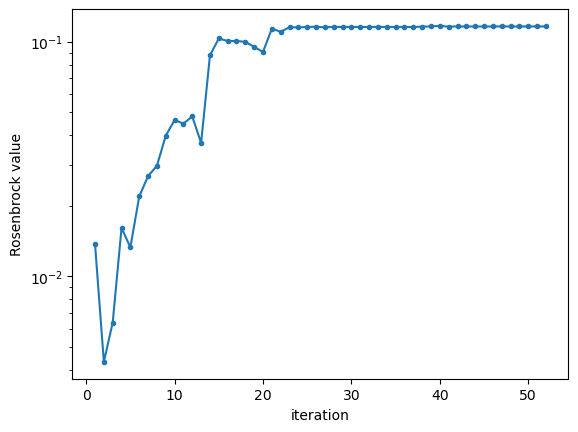

In [70]:
import matplotlib.pyplot as plt
X.data['f'].plot(marker='.')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Rosenbrock value')
best=dict(X.data.iloc[X.data["f"].argmax()]);

if normalize:
    for key in yaml_output['vocs']['variables'].keys():
        best[key] = unnormalize_var(key, best[key])

best